In [1]:
import pandas as pd
import psycopg2
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
import numpy as np
from collections import Counter
import time 
main_path = '/home/fs01/spec1142/Emma/'

In [2]:
publication_dates = pd.read_csv(main_path + "PPPs/published_application_small.tsv", index_col = 0  )

## Links pairs and PPPs

In [3]:
PPPs = pd.read_csv(main_path+'PPPs/PPPs_v1.tsv', delimiter = '\t', index_col = 0 )

In [4]:
PPPs

,PV_id_OA_id,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,...,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,original_parent,difference_original_patent_app_paper,all_patents_for_a_same_paper,citations,PPP_citations
0,US-10161940 W2588336857,0.555671,0.513315,815.0,-1367.0,journal-article,3,100.000000,1.721438,W2588336857,...,"#N#5#N#BioNTech Cell & Gene Therapies GmbH, Ma...","healthcare, education, facility",NaN,NaN,0.0,PCT/EP2013/050048,-1367.0,NaN,0.0,0.0
1,US-6989377 W2075251022,0.545126,0.602090,2213.0,892.0,journal-article,2,100.000000,2.332551,W2075251022,...,"University of Wisconsin–Madison, University of...","healthcare, education",UNIVERSITY,Wisconsin Alumni Research Foundation,0.0,US-6358939,-13.0,NaN,0.0,0.0
2,US-6989377 W2189513341,0.640873,0.522754,1060.0,-261.0,journal-article,2,100.000000,2.332551,W2189513341,...,University of Wisconsin–Madison,education,UNIVERSITY,Wisconsin Alumni Research Foundation,0.0,US-6358939,-1166.0,NaN,0.0,0.0
3,US-6602920 W2520930298,0.927995,0.514957,581.0,-298.0,journal-article,6,120.000000,NaN,W2520930298,...,NaN,NaN,UNIVERSITY,The Texas A&M University System,0.0,US-6130260,-1133.0,same title,0.0,0.0
4,US-6058344 W2143438404,0.697616,0.534049,968.0,628.0,proceedings-article,2,100.000000,3.939116,W2143438404,...,Carnegie Mellon University,education,UNIVERSITY,Carnegie Mellon University,0.0,US-5908458,-213.0,"same abstract, same title",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222369,US-11134860 W2982506142,0.672014,0.561713,821.0,-11.0,proceedings-article,6,100.000000,0.645130,W2982506142,...,"American University of Beirut, Fahad Bin Sulta...",education,NaN,American University of Beirut,0.0,62690110,-376.0,NaN,NaN,NaN
222373,US-11166810 W3022029710,0.629991,0.304310,6909.0,5714.0,journal-article,1,25.000000,8982.649028,W3022029710,...,University of Rouen,education,NaN,Edwards Lifesciences Corporation,0.0,US-6893460,-425.0,same parent,NaN,NaN
222374,US-10975139 W3034548712,0.778892,0.546722,235.0,-3.0,journal-article,6,46.153846,2.970900,W3034548712,...,Regeneron,company,COMPANY,"Regeneron Pharmaceuticals, Inc.",0.0,63004312,-141.0,"same parent, same abstract, same title",NaN,NaN
222375,US-11002812 W3101797731,0.571606,0.308062,1170.0,696.0,journal-article,2,100.000000,1.991794,W3101797731,...,"University of Illinois Urbana-Champaign, Unive...",education,COMPANY,Quantum Valley Investment Fund LP,0.0,US-10585154,-28.0,NaN,NaN,NaN


In [15]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')

In [5]:
len(set(list(PPPs['patent_id'])))

187427

In [6]:
def get_dates_patents(i):

    dic = {}

    list_patents = list(set(PPPs['patent_id'].to_list()))
    list_index = [ k for k in range(i,len(list_patents),96) ] 
    
    conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU") 
    cursor = conn.cursor()
    
    for k in list_index:
        patent_id = list_patents[k][3:]
        
            
        text = """ SELECT p.patent_date , ap.filing_date, application_id
                   FROM patents_PatentsView AS p 
                   JOIN applications_PatentsView AS ap ON ap.patent_id = '""" + patent_id + """'
                   WHERE p.patent_id = '""" + patent_id + """';"""
        
        cursor.execute(text)
        res = cursor.fetchall()
        
        for line in res:
            dic[patent_id] = {}
            dic[patent_id]["patent_id"] = list_patents[k]
            dic[patent_id]["grant_date"] = line[0]
            dic[patent_id]["application_date"] = line[1]
            dic[patent_id]["application_id"] = line[2]
    
    cursor.close()

    return dic
    

In [7]:
p = Pool(processes=96)
func = partial(get_dates_patents)
results = p.map(func, [ i  for i in range(96)])
p.close()

In [8]:
dic_dates = {} 
for dic in results:
    dic_dates = { **dic_dates , **dic}
print(len(dic_dates))

187427


In [9]:
dates_patents = pd.DataFrame(dic_dates).T
dates_patents

,patent_id,grant_date,application_date,application_id
8212088,US-8212088,2012-07-03,2009-08-07,12537647
6833726,US-6833726,2004-12-21,2004-02-13,10779093
9873759,US-9873759,2018-01-23,2015-11-24,14951123
5616589,US-5616589,1997-04-01,1994-08-09,08287421
8697068,US-8697068,2014-04-15,2010-04-28,12769599
...,...,...,...,...
9641805,US-9641805,2017-05-02,2016-03-18,15073928
5655137,US-5655137,1997-08-05,1995-03-23,08409256
8458171,US-8458171,2013-06-04,2009-07-30,12512908
10291419,US-10291419,2019-05-14,2015-09-08,14848160


In [10]:
publication_dates = pd.read_csv(main_path + "PPPs/published_application_small.tsv", index_col = 0  )

In [11]:
PPPs['patent_id'] = PPPs['patent_id'].astype(str)
dates_patents['patent_id'] = dates_patents['patent_id'].astype(str)

PPPs_dates = PPPs.merge(dates_patents[["grant_date" , "application_date","application_id",'patent_id']] , on = "patent_id" , how = "left")
PPPs_dates = PPPs_dates.sort_values(["patent_id" , "application_date","application_date"]).drop_duplicates("patent_id" , keep='first')
#PPPs_dates["application_id"] = [ int(elem.split("/")[-1]) for elem in PPPs_dates["application_id"]]



In [12]:
PPPs_dates['application_id'] = PPPs_dates['application_id'].astype(int)


In [13]:
PPPs_dates = PPPs_dates.merge(publication_dates , left_on = "application_id" , right_on = "application_id" , how= "left")
PPPs_dates['published_date'] = pd.to_datetime(PPPs_dates['published_date'])
PPPs_dates['application_date'] = pd.to_datetime(PPPs_dates['application_date'])
PPPs_dates['grant_date'] = pd.to_datetime(PPPs_dates['grant_date'])


In [14]:
PPPs_dates['application_year'] = PPPs_dates['application_date'].dt.year
PPPs_dates['grant_year'] = PPPs_dates['grant_date'].dt.year
PPPs_dates['published_year'] = PPPs_dates['published_date'].dt.year

In [15]:
PPP_dates_small = PPPs_dates[['PV_id_OA_id','application_year', 'grant_year', 'published_year','paper_id', 'patent_id','PPP_score']]
PPP_dates_small['paper_id'] = [ int(elem[1:]) for elem in PPP_dates_small['paper_id']]

/tmp/ipykernel_335979/3685493643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPP_dates_small['paper_id'] = [ int(elem[1:]) for elem in PPP_dates_small['paper_id']]


In [93]:
PPP_dates_small = PPP_dates_small.merge(controls, left_on = [ 'grant_year', 'application_year','paper_id'], right_on = ['grant_year','app_year','paper_id'], how = 'right')





In [110]:
PPP_dates_small[PPP_dates_small['ppp'] == 1]

,PV_id_OA_id,application_year,grant_year,published_year,paper_id,patent_id,PPP_score,v1,pair_id,score,...,lpost_pub_pre_grant_self,lpre_grant_self,lpost_grant_self,apppublished,magid,lifesci,firstpage,lastpage,pagelength,numbackwardcites
0,US-8410333 W254201,2009.0,2013,2010.0,2.542010e+05,US-8410333,3.0,174558,loose_twin_106981,NaN,...,0.0,0.000000,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
1,US-8652842 W254201,2013.0,2014,2013.0,2.542010e+05,US-8652842,3.0,185354,loose_twin_113721,NaN,...,0.0,0.000000,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
2,US-7129084 W254201,2001.0,2006,2003.0,2.542010e+05,US-7129084,1.0,118990,loose_twin_72395,NaN,...,0.0,0.000000,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
3,US-7585668 W254201,2004.0,2009,2006.0,2.542010e+05,US-7585668,3.0,138156,loose_twin_84134,NaN,...,0.0,0.000000,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
8,US-7455700 W478334,2007.0,2008,2007.0,4.783340e+05,US-7455700,2.0,132578,loose_twin_80675,NaN,...,0.0,0.000000,0.000000,1,4.783340e+05,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267562,US-7504493 W4213265720,2004.0,2009,2007.0,4.213266e+09,US-7504493,3.0,134600,loose_twin_81928,NaN,...,0.0,2.564949,0.000000,1,4.213266e+09,0,NaN,NaN,NaN,0
267571,US-10463709 W4213349070,2016.0,2019,2018.0,4.213349e+09,US-10463709,1.0,20242,loose_twin_12735,NaN,...,0.0,0.000000,0.000000,1,4.213349e+09,0,NaN,NaN,NaN,0
267573,US-11027121 W4213370460,2019.0,2021,2019.0,4.213370e+09,US-11027121,3.0,44030,loose_twin_27690,NaN,...,0.0,0.000000,0.000000,1,4.213370e+09,0,NaN,NaN,NaN,0
267577,US-10912850 W4213425433,2017.0,2021,2019.0,4.213425e+09,US-10912850,3.0,39198,loose_twin_24627,NaN,...,0.0,0.000000,0.693147,1,4.213425e+09,0,NaN,NaN,NaN,0


In [111]:
PPP_dates_small[PPP_dates_small['PV_id_OA_id'].notnull()][['PV_id_OA_id','pair_id']].to_csv(main_path + 'PPPs/link_pairs_ppps.tsv', sep = '\t', index = False)

In [3]:
PPP_dates_small = pd.read_csv(main_path + 'PPPs/link_pairs_ppps.tsv', delimiter = '\t')




In [12]:
count =PPP_dates_small.groupby('PV_id_OA_id').count()
count[count['pair_id'] > 1]

,pair_id
PV_id_OA_id,
US-10000499 W2586171921,2
US-10000500 W2432000892,2
US-10000533 W2980167922,2
US-10000539 W1527445381,15
US-10000540 W2165183020,3
...,...
US-9994813 W2163636666,2
US-9994844 W2267187439,6
US-9994850 W1981430299,3


In [7]:
len(set(list(PPP_dates_small['PV_id_OA_id'])))

122541

## Functions

In [77]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [78]:
path = "/home/fs01/spec1142/Emma/test/Website/"

def load_array(year ):
    
    array_abstract = np.load(path + 'data/paper_abstract_array/abstracts' + str(year) + '.npy')
    array_patents = np.load(path + 'data/paper_abstract_array/papers' + str(year) + '.npy')

    return array_abstract, array_patents

In [79]:
def get_abstract(year,workers, i):

    list_abstract = []
    list_papers = []
    
    papers_year = list(file[file['paperpubyear'] == year]['paper_id'])   
    list_index = [ k for k in range(i,len(papers_year),workers) ] 
    
    
    conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU") 
    cursor = conn.cursor()
    
    for k in list_index:
        work_id = "W" + str(papers_year[k])
        
            
        text = """select  work_id , encoded_abstract
                  from encoded_works_OpenAlex 
                  where work_id = '""" + work_id + """'
                    ;"""
        cursor.execute(text)
        res = cursor.fetchall()
        if len(res) > 0:
            list_papers.append(res[0][0])
            list_abstract.append(clean_encoding(res[0][1]))
    
    cursor.close()

    return list_papers , list_abstract
    

In [80]:
def count_similarity( list_abstracts , list_papers, threshold1 , threshold2,threshold3 , year):
    
    k=0    
    array_abstract, array_patents = load_array(year)
    size = len(array_abstract)
    print(size)

    array_return1 = np.zeros((len(list_abstracts)))
    array_return2 = np.zeros((len(list_abstracts)))
    array_return3 = np.zeros((len(list_abstracts)))

    for k in range(1+size//100000):
        knowlegde = np.transpose(array_abstract[100000*k:100000*(k+1),:])
        count1 , count2, count3 = matrix_multiplication(list_abstracts, knowlegde, threshold1 , threshold2,threshold3 )
        array_return1 += count1
        array_return2 += count2
        array_return3 += count3
        
    print(year)
    return array_return1 , array_return2, array_return3
    

In [81]:
def matrix_multiplication(a,b,threshold1,threshold2,threshold3):
    a = np.array(a,dtype = np.float32)
    b = np.array(b,dtype = np.float32)
    similarity = a.dot(b)
    list_counts1 = np.sum(similarity > threshold1, axis=1)
    list_counts2 = np.sum(similarity > threshold2, axis=1)
    list_counts3 = np.sum(similarity > threshold3, axis=1)
    similarity=0
        
    return list_counts1 , list_counts2,list_counts3

## Plot

In [19]:
conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU") 
cursor = conn.cursor()
    
    
        
text = """select  work_id , encoded_abstract
              from encoded_works_OpenAlex 
              where work_id = '""" + 'W1535266' + """'
                ;"""
cursor.execute(text)
res = cursor.fetchall()

In [20]:
list_papers = [res[0][0]]
list_abstracts = [ clean_encoding(res[0][1])]
list_papers = np.array(list_papers)
list_abstracts = np.array(list_abstracts)    

In [21]:
array_abstract, array_patents = load_arrays(2005,2007)

In [22]:
similarity = array_abstract.dot(np.transpose(list_abstracts))

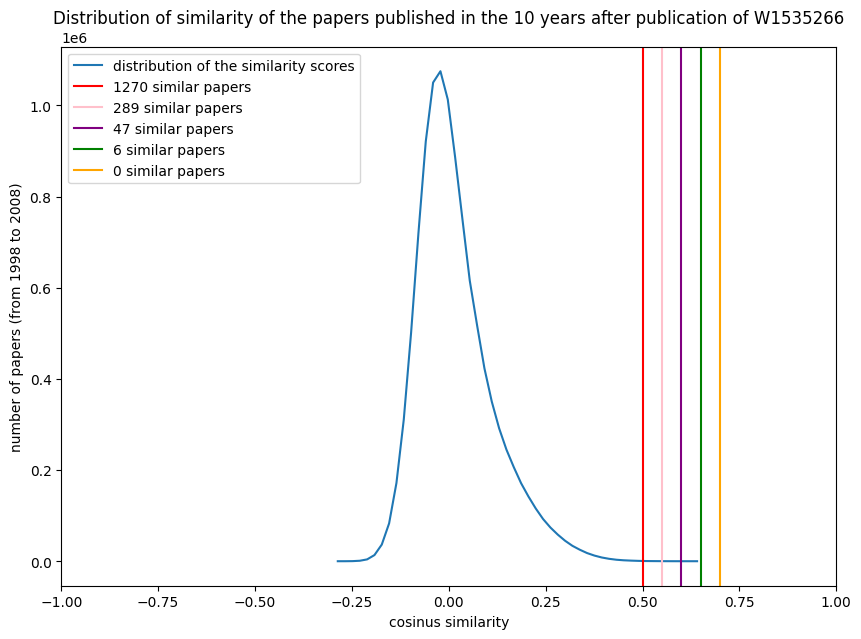

In [37]:
import matplotlib.pyplot as plt 
dist = np.histogram(similarity, bins = 50)
plt.figure(figsize=(10,7))
plt.plot(dist[1][:-1], dist[0], label = 'distribution of the similarity scores')
plt.axvline(x = 0.5, color = 'red', label = '1270 similar papers')
plt.axvline(x = 0.55, color = 'pink', label = '289 similar papers')
plt.axvline(x = 0.6, color = 'purple', label = '47 similar papers')
plt.axvline(x = 0.65, color = 'green', label = '6 similar papers')
plt.axvline(x = 0.7, color = 'orange', label = '0 similar papers')
plt.xlabel('cosinus similarity')
plt.ylabel('number of papers (from 1998 to 2008)')
plt.title('Distribution of similarity of the papers published in the 10 years after publication of W1535266')
plt.xlim([-1,1])
plt.legend()
plt.show()

## Get similar papers counts

In [82]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')


In [86]:
file = controls[['paper_id','pair_id','paperpubyear','app_pub_year','grant_year']]
file['paper_id'] = file['paper_id'].astype('int')
file.head()

/tmp/ipykernel_335979/3662321812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['paper_id'] = file['paper_id'].astype('int')


,paper_id,pair_id,paperpubyear,app_pub_year,grant_year
0,254201,loose_twin_106981,2007,2010.0,2013
1,254201,loose_twin_113721,2007,2013.0,2014
2,254201,loose_twin_72395,2007,2003.0,2006
3,254201,loose_twin_84134,2007,2006.0,2009
4,267833,loose_twin_84190,2005,2007.0,2009


### 5 years before

In [75]:
threshold1 = 0.6
threshold2 = 0.64
threshold3 = 0.68

workers = 6
for year in range(1980,2017):

    ##get the abstracts of the papers published in 'year'
    p = Pool(processes=workers)
    func = partial(get_abstract, year,workers)
    abstracts = p.map(func, [ i  for i in range(workers)])
    p.close()

    ##organize the abstract into an array
    list_papers = []
    list_abstracts = []
    
    for elem in abstracts:
        list_papers += elem[0]
        list_abstracts += elem[1]

    if len(list_papers) > 0:
    
        list_papers = np.array(list_papers)
        list_abstracts = np.array(list_abstracts, dtype=np.float32)    

        print('step1') ##the abstracts are in the array
        

        ##count the number of similar papers between year and year + 10
        #p = Pool(len([ i  for i in range(year+1,min(2023,year+11))]))
        #func = partial(count_similarity,list_abstracts,list_papers, threshold1,threshold2,threshold3)
        #count_similarities = p.map(func, [ i  for i in range(year+1,min(2023,year+11))])
        #p.close()

        ##count the number of similar papers between year - 5 and year
        p = Pool(len([ i  for i in range(year-5,year+1)]))
        func = partial(count_similarity,list_abstracts,list_papers, threshold1,threshold2,threshold3)
        count_similarities = p.map(func, [ i  for i in range(year-5,year+1)])
        p.close()
        
        
        print('step2') ##we have the count of similar papers
        
        count_similarities = np.array(count_similarities)
        count_similarities1 = count_similarities[:,0,:]
        count_similarities2 = count_similarities[:,1,:]
        count_similarities3 = count_similarities[:,2,:]
        file_year = file[file['paperpubyear'] == year]
        df = pd.DataFrame()
        df['paper_id'] = [ int(elem[1:]) for elem in list_papers ] 
        last = 5
        for k in range(len(count_similarities)):
            df['count_before_' + str(last-k) + '_' + str(threshold1)] = count_similarities1[k]
            df['count_before_' + str(last-k) + '_' + str(threshold2)] = count_similarities2[k]
            df['count_before_' + str(last-k) + '_' + str(threshold3)] = count_similarities3[k]
        

        file_year = file_year.merge(df , on = 'paper_id' , how = 'left')
        
        file_year.to_csv(main_path + 'PPPs/counts_before_' + str(year) + '.tsv' , sep = "\t")
        



step1
3677081
3305033
4016398
3034442
4329530
2741804
2004
2005
2006
2003
2007
2008
step2
step1
3677081
4016398
3305033
4329530
4764058
3034442
2005
2006
2004
2007
2008
2009
step2
step1
3305033
3677081
4016398
4764058
4329530
5235909
2005
2006
2007
2008
2009
2010
step2
step1
5235909
3677081
4016398
4764058
4329530
5443757
2006
2007
2008
2009
2010
2011
step2
step1
5235909
5443757
4016398
4764058
4329530
5694801
2007
2008
2009
2010
2011
2012
step2
step1
5235909
5443757
5694801
4764058
4329530
6030926
2008
2009
2010
2011
2012
2013
step2
step1
5443757
5235909
5694801
4764058
6030926
6125705
2009
2010
2011
2012
2013
2014
step2
step1
5235909
5443757
6030926
5694801
6125705
6122841
2010
2011
2012
2013
2014
2015
step2
step1
5443757
6030926
5694801
6125705
6122841
5927799
2012
2011
2015
2013
2014
2016
step2


## 10 years after

In [ ]:
threshold1 = 0.6
threshold2 = 0.64
threshold3 = 0.68

workers = 6
for year in range(1990,2000):

    ##get the abstracts of the papers published in 'year'
    p = Pool(processes=workers)
    func = partial(get_abstract, year,workers)
    abstracts = p.map(func, [ i  for i in range(workers)])
    p.close()

    ##organize the abstract into an array
    list_papers = []
    list_abstracts = []
    
    for elem in abstracts:
        list_papers += elem[0]
        list_abstracts += elem[1]

    if len(list_papers) > 0:
    
        list_papers = np.array(list_papers)
        list_abstracts = np.array(list_abstracts, dtype=np.float32)    

        print('step1') ##the abstracts are in the array
        

        ##count the number of similar papers between year and year + 10
        p = Pool(len([ i  for i in range(year+1,min(2023,year+11))]))
        func = partial(count_similarity,list_abstracts,list_papers, threshold1,threshold2,threshold3)
        count_similarities = p.map(func, [ i  for i in range(year+1,min(2023,year+11))])
        p.close()

        ##count the number of similar papers between year - 5 and year
        #p = Pool(len([ i  for i in range(year-5,year+1)]))
        #func = partial(count_similarity,list_abstracts,list_papers, threshold1,threshold2,threshold3)
        #count_similarities = p.map(func, [ i  for i in range(year-5,year+1)])
        #p.close()
        
        
        print('step2') ##we have the count of similar papers
        
        count_similarities = np.array(count_similarities)
        count_similarities1 = count_similarities[:,0,:]
        count_similarities2 = count_similarities[:,1,:]
        count_similarities3 = count_similarities[:,2,:]
        file_year = file[file['paperpubyear'] == year]
        df = pd.DataFrame()
        df['paper_id'] = [ int(elem[1:]) for elem in list_papers ] 
        
        for k in range(len(count_similarities)):
            df['count_after_' + str(k+1) + '_' + str(threshold1)] = count_similarities1[k]
            df['count_after_' + str(k+1) + '_' + str(threshold2)] = count_similarities2[k]
            df['count_after_' + str(k+1) + '_' + str(threshold3)] = count_similarities3[k]
        

        file_year = file_year.merge(df , on = 'paper_id' , how = 'left')
        file_year = file_year.drop_duplicates()
        
        file_year.to_csv(main_path + 'PPPs/counts_after_' + str(year) + '.tsv' , sep = "\t")
        


step1
1241929
1321879
1180463
1126952
1399364
1475832
1528314
1630562
1733238
1974082
1991
1992
1993
1994
1995
1998
1996
1997
1999
2000
step2
step1
11804631241929

1321879
1399364
1475832
1528314
1630562
1733238
1974082
1992
1994
1993
1995
1996
1997
1998
1999
2000
2150653
2001
step2
step1
1241929
1321879
1399364
1475832
1528314
1630562
1733238
1974082


In [142]:
for k in range(len(count_similarities)):
    file_year['count_year_' + str(k) + '_' + str(threshold1)] = count_similarities1[k]
    file_year['count_year_' + str(k) + '_' + str(threshold2)] = count_similarities2[k]
    file_year['count_year_' + str(k) + '_' + str(threshold3)] = count_similarities3[k]

file_year.to_csv(main_path + 'PPPs/counts_' + str(year) + '.tsv' , sep = "\t")

/tmp/ipykernel_443113/3783396445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_year['count_year_' + str(k) + '_' + str(threshold1)] = count_similarities1[k]
/tmp/ipykernel_443113/3783396445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_year['count_year_' + str(k) + '_' + str(threshold2)] = count_similarities2[k]
/tmp/ipykernel_443113/3783396445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [141]:
len(count_similarities)

9

In [143]:
file_year

,paper_id,pair_id,paperpubyear,app_pub_year,grant_year,count_year_0_0.6,count_year_0_0.64,count_year_0_0.68,count_year_1_0.6,count_year_1_0.64,...,count_year_5_0.68,count_year_6_0.6,count_year_6_0.64,count_year_6_0.68,count_year_7_0.6,count_year_7_0.64,count_year_7_0.68,count_year_8_0.6,count_year_8_0.64,count_year_8_0.68
43,4428081,loose_twin_22088,2013,2019.0,2020,256.0,104.0,37.0,342.0,137.0,...,73.0,289.0,131.0,79.0,286.0,96.0,58.0,230.0,90.0,39.0
44,4428081,loose_twin_22479,2013,2019.0,2020,163.0,48.0,14.0,184.0,53.0,...,10.0,190.0,30.0,6.0,186.0,39.0,10.0,125.0,21.0,2.0
45,4428081,loose_twin_22671,2013,2019.0,2020,407.0,221.0,101.0,409.0,237.0,...,77.0,553.0,242.0,111.0,556.0,285.0,129.0,436.0,203.0,94.0
47,4527426,loose_twin_4924,2013,2016.0,2019,32.0,8.0,6.0,35.0,2.0,...,1.0,36.0,2.0,1.0,48.0,5.0,0.0,48.0,3.0,0.0
48,4527426,loose_twin_11563,2013,2016.0,2019,119.0,80.0,52.0,93.0,54.0,...,33.0,69.0,42.0,22.0,65.0,36.0,28.0,42.0,22.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244678,3176184629,loose_twin_150844,2013,2017.0,2018,79.0,30.0,15.0,68.0,24.0,...,20.0,121.0,50.0,18.0,199.0,88.0,34.0,132.0,58.0,27.0
244876,3185893103,loose_twin_130824,2013,2015.0,2016,288.0,106.0,35.0,252.0,77.0,...,10.0,99.0,32.0,15.0,110.0,20.0,13.0,65.0,13.0,4.0
244877,3185893103,loose_twin_149160,2013,2017.0,2018,53.0,23.0,12.0,56.0,22.0,...,10.0,61.0,20.0,8.0,56.0,19.0,6.0,44.0,15.0,7.0
244878,3185893103,loose_twin_138933,2013,2016.0,2017,1.0,1.0,1.0,2.0,2.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
##organize the counts into an array of the good shape
        count_similarities = np.array(count_similarities).reshape(shape,2,-1)
        print(count_similarities.shape)

In [ ]:
##for each paper, get the file to store the result
        df = file[file['paperpubyear'] == year]
        df['paper_id_pair_id'] = df['paper_id'].astype('str') + "%" + df['pair_id']
        dic_df = df.set_index('paper_id_pair_id').to_dict('index')
        
        dic_papers = {}
        for elem in dic_df:
            paper_id , pair_id = elem.split('%')
            if paper_id not in dic_papers:
                dic_papers[paper_id] = {}
            dic_papers[paper_id][pair_id] = {}
            dic_papers[paper_id][pair_id] = dic_df[elem]
        
        
        
        print('step3')
        
        
        dic_count = {}
        pair_ids = np.empty((len(df)),dtype='O')
        work_ids = np.zeros((len(df)))
        count_before_app = np.zeros((len(df)))
        count_between_grant_app = np.zeros((len(df)))
        count_aft_grant = np.zeros((len(df)))
        count_before_paper_pub_pub = np.zeros((len(df)))
        count_before_paper_pub_grant = np.zeros((len(df)))
        count_before_grant = np.zeros((len(df)))

        set_done = set()
        
        counter = 0 
        for k in tqdm(range(len(list_papers))):
            paper_id = list_papers[k][1:]
            counts = count_similarities[:,k]
            for pair_id in dic_papers[paper_id]:
        
                if paper_id + '&' + pair_id not in set_done:
                
                    work_ids[counter] = paper_id
                    pair_ids[counter] = pair_id
                    
                    paper_pub = dic_papers[paper_id][pair_id]['paperpubyear']
                    grant_year = dic_papers[paper_id][pair_id]['grant_year']
                    patent_pub = dic_papers[paper_id][pair_id]['app_pub_year']

                    if pd.isna(patent_pub) == False:
                    
                        count_before_app[counter] = counts[0:int(max(patent_pub-paper_pub,0))].sum()
                        count_between_grant_app[counter] = counts[int(max(patent_pub-paper_pub,0)):int(max(grant_year-paper_pub,0))].sum()
                        count_aft_grant[counter] = counts[int(max(grant_year-paper_pub,0)):].sum()
                        count_before_grant[counter] = count_before_app[counter] + count_between_grant_app[counter]
                        
                        counter += 1
                        set_done.add(paper_id + '&' + pair_id )

                    else:
                        count_before_app[counter] = None
                        count_between_grant_app[counter] = None
                        count_aft_grant[counter] = counts[int(max(grant_year-paper_pub,0)):].sum()
                        count_before_grant[counter] = counts[:int(max(grant_year-paper_pub,0)].sum()
                        
                        counter += 1
                        set_done.add(paper_id + '&' + pair_id )
                        
        
        print('step4')
        
        
        df = pd.DataFrame()
        df['paper_id'] = work_ids
        df['pair_id'] = pair_ids
        df['count_before_app'] = count_before_app
        df['count_between_grant_app'] = count_between_grant_app
        df['count_aft_grant'] = count_aft_grant
        df.to_csv(main_path + '/PPPs/count_similar_papers_threshold075_' + str(year) + '.tsv' , sep = "\t")

In [19]:
df = pd.concat( [ pd.read_csv(main_path + '/PPPs/count_similar_papers_threshold075_' + str(year) + '.tsv' , delimiter = "\t", index_col = 0 ) for year in range(1983,2017)])
file = controls[controls['app_pub_year'].notnull()][['paper_id','pair_id','paperpubyear','app_pub_year','grant_year']]


In [20]:
df_merged = df.merge(file, on= ['paper_id','pair_id'],how = 'right')

In [21]:
df_merged[ (df_merged['paperpubyear'] <= 2016 ) & (df_merged['paperpubyear'] >= 1983 )]

,paper_id,pair_id,count_before_app,count_between_grant_app,count_aft_grant,paperpubyear,app_pub_year,grant_year
0,2.542010e+05,loose_twin_106981,0.0,0.0,0.0,2007,2010.0,2013
1,2.542010e+05,loose_twin_113721,0.0,0.0,0.0,2007,2013.0,2014
2,2.542010e+05,loose_twin_72395,0.0,0.0,0.0,2007,2003.0,2006
3,2.542010e+05,loose_twin_84134,0.0,0.0,0.0,2007,2006.0,2009
4,2.678330e+05,loose_twin_84190,0.0,0.0,0.0,2005,2007.0,2009
...,...,...,...,...,...,...,...,...
186313,4.213313e+09,loose_twin_7765,0.0,0.0,0.0,2014,2019.0,2019
186314,4.213313e+09,loose_twin_6974,0.0,0.0,0.0,2014,2017.0,2019
186315,4.213313e+09,loose_twin_149439,0.0,0.0,0.0,2014,2017.0,2018
186320,4.213387e+09,loose_twin_87760,0.0,0.0,0.0,2002,2005.0,2010


In [22]:
df_merged[ (df_merged['paperpubyear'] <= 2016 ) & (df_merged['paperpubyear'] >= 1983 )].to_csv('/home/fs01/spec1142/Emma/' + '/PPPs/count_similar_papers_with_patentpub_threshold075.tsv', index = False, sep ='\t')


In [11]:
import time

start = time.time()

##get the abstracts of the papers published in 'year'
p = Pool(processes=12)
func = partial(get_abstract, 2009)
abstracts = p.map(func, [ i  for i in range(12)])
p.close()

end = time.time()
print(end - start)

3.0099036693573


In [14]:
##organize the abstract into an array
list_papers = []
list_abstracts = []

for elem in abstracts:
    list_papers += elem[0]
    list_abstracts += elem[1]

list_papers = np.array(list_papers)
list_abstracts = np.array(list_abstracts, dtype=np.float16)    

In [18]:
start = time.time() 

array_return1 = np.zeros((3,len(list_abstracts)),dtype=np.float16)
array_return2 = np.zeros((3,len(list_abstracts)),dtype=np.float16)
k=0
year = 2009
next_year = year +1

array_abstract, array_patents = load_array(next_year)

end = time.time()
print(end - start)

10.07012939453125


In [19]:
array_abstract.shape

(5235909, 384)

In [20]:
list_abstracts.shape

(10191, 384)

In [ ]:
start = time.time() 
similarity = array_abstract.dot(np.transpose(list_abstracts))  
end = time.time()
print(end - start)

In [ ]:
similarity = array_abstract.dot(np.transpose(list_abstracts))  

list_counts = np.sum(similarity > threshold1, axis=0)
array_return1[k] = list_counts
list_counts = np.sum(similarity > threshold2, axis=0)
array_return2[k] = list_counts
similarity=0
k += 1
print(next_year)

return array_return1 , array_return2

In [9]:
from os import environ
environ['OMP_NUM_THREADS'] = '4'
from time import time
from numpy.random import rand

n=10000

# record start time
start = time()
# create an array of random values
data1 = rand(n, n)
data2 = rand(n, n)
# matrix multiplication
result = data1.dot(data2)
# calculate the duration in seconds
duration = time() - start
print(duration)

3.8000786304473877


## New code

In [89]:
def matrix_multiplication(a,b,threshold1,threshold2):
    start = time.time()
    a = np.array(a,dtype = np.float32)
    b = np.array(b,dtype = np.float32)
    print(time.time() - start)
    similarity = a.dot(b)
    print(time.time() - start)
    list_counts1 = np.sum(similarity > threshold1, axis=1)
    print(time.time() - start)
    list_counts2 = np.sum(similarity > threshold2, axis=1)
    print(time.time() - start)
    similarity=0
        
    return list_counts1 , list_counts2
    

In [9]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')


In [10]:
file = controls[['paper_id','pair_id','paperpubyear','app_pub_year','grant_year']]
file['paper_id'] = file['paper_id'].astype('int')
file.head()

/tmp/ipykernel_443113/3662321812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['paper_id'] = file['paper_id'].astype('int')


,paper_id,pair_id,paperpubyear,app_pub_year,grant_year
0,254201,loose_twin_106981,2007,2010.0,2013
1,254201,loose_twin_113721,2007,2013.0,2014
2,254201,loose_twin_72395,2007,2003.0,2006
3,254201,loose_twin_84134,2007,2006.0,2009
4,267833,loose_twin_84190,2005,2007.0,2009


In [11]:
import time

start = time.time()

##get the abstracts of the papers published in 'year'
p = Pool(processes=12)
func = partial(get_abstract, 2009)
abstracts = p.map(func, [ i  for i in range(12)])
p.close()

end = time.time()
print(end - start)

1.6223912239074707


In [12]:
##organize the abstract into an array
list_papers = []
list_abstracts = []

for elem in abstracts:
    list_papers += elem[0]
    list_abstracts += elem[1]

list_papers = np.array(list_papers)
list_abstracts = np.array(list_abstracts, dtype=np.float16)    

In [13]:
start = time.time() 

array_return1 = np.zeros((3,len(list_abstracts)),dtype=np.float16)
array_return2 = np.zeros((3,len(list_abstracts)),dtype=np.float16)
k=0
year = 2009
next_year = year +1

array_abstract, array_patents = load_array(next_year)

end = time.time()
print(end - start)

6.309006452560425


In [55]:
k = 0 
small_array = array_abstract[100000*k:100000*(k+1),:]

In [59]:
list_abstracts.shape

(10191, 384)

In [90]:
start = time.time()

list_counts1 = np.zeros((10191))
list_counts2 = np.zeros((10191))

for k in tqdm(range(1)):
    knowlegde = np.transpose(array_abstract[100000*k:100000*(k+1),:])
    count1 , count2 = matrix_multiplication(list_abstracts, knowlegde, 0.65,0.7)
    list_counts1 += count1
    list_counts2 += count2
    end = time.time()
    print(end - start)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0.14786863327026367
1.2195453643798828
2.756199598312378


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]

3.53838849067688
3.5499136447906494


## Concat files

In [34]:
import pandas as pd 
from tqdm import tqdm 
main_path = '/home/fs01/spec1142/Emma/'

file = pd.concat( [ pd.read_csv(main_path + 'PPPs/counts_' + str(year) + '.tsv' , sep = "\t", index_col = 0) for year in range(1980,2017) ] )
file = file.drop_duplicates()
file= file.reset_index()
file = file.drop(['index'],axis = 1)

file2 = pd.concat( [ pd.read_csv(main_path + 'PPPs/counts_before_' + str(year) + '.tsv' , sep = "\t", index_col = 0) for year in range(1980,2017) ] )
file2 = file2.drop_duplicates()
file2= file2.reset_index()
file2 = file2.drop(['index'],axis = 1)


In [35]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')

In [36]:
file = file.merge(controls[['paper_id', 'pair_id','app_year']], on=['paper_id', 'pair_id'], how='left')

In [37]:
file = file.merge(file2[['paper_id', 'pair_id','count_before_5_0.6', 'count_before_5_0.64', 'count_before_5_0.68',
       'count_before_4_0.6', 'count_before_4_0.64', 'count_before_4_0.68',
       'count_before_3_0.6', 'count_before_3_0.64', 'count_before_3_0.68',
       'count_before_2_0.6', 'count_before_2_0.64', 'count_before_2_0.68',
       'count_before_1_0.6', 'count_before_1_0.64', 'count_before_1_0.68',
       'count_before_0_0.6', 'count_before_0_0.64', 'count_before_0_0.68']], on=['paper_id', 'pair_id'] , how = 'inner')

In [39]:
dic_file = file.to_dict('index')


In [42]:
for elem in tqdm(dic_file):
        
    paper_pub = dic_file[elem]['paperpubyear']
    

    for threshold in [ 0.6,0.64,0.68 ] :

        for k in range(10):
            
            column = 'count_year_' + str(k) + '_' + str(threshold)
            year = paper_pub + 1 + k  
            dic_file[elem]["count_" + str(year) + "_" + str(threshold)] =  dic_file[elem][column]

        for k in range(6):
            column = 'count_before_' + str(k) + '_' + str(threshold)
            year = paper_pub - k 
            dic_file[elem]["count_" + str(year) + "_" + str(threshold)] =  dic_file[elem][column]
            

100%|████████████████████████████████| 218083/218083 [00:16<00:00, 12893.27it/s]


In [52]:
dic = {}
count = 0 

for elem in tqdm(dic_file):
        
    dic[count] = {}
    paper_pub = dic_file[elem]['paperpubyear']
    grant_year = dic_file[elem]['grant_year']
    patent_pub = dic_file[elem]['app_pub_year'] 
    patent_app = dic_file[elem]['app_year'] 

    dic[count]['paper_id'] = dic_file[elem]['paper_id']
    dic[count]['pair_id'] = dic_file[elem]['pair_id']

    dic[count]['paper_pub'] = paper_pub
    dic[count]['patent_pub'] = patent_pub
    dic[count]['grant_year'] = grant_year
    dic[count]['patent_app'] = patent_app

    for threshold in [ 0.6,0.64,0.68 ] :

        dic[count]['count_before_grant' + str(threshold)] = 0 
        dic[count]['count_same_grant' + str(threshold)] = 0 
        dic[count]['count_aft_grant' + str(threshold)] = 0 
    
        dic[count]['count_before_paper_pub' + str(threshold)] = 0 
        dic[count]['count_same_paper_pub' + str(threshold)] = 0 
        dic[count]['count_after_paper_pub' + str(threshold)] = 0
    
        if pd.isna(patent_pub) == False:
    
            dic[count]['count_before_app_pub' + str(threshold)] = 0 
            dic[count]['count_same_app_pub' + str(threshold)] = 0 
            dic[count]['count_after_app_pub' + str(threshold)] = 0 
    
            for year in range(paper_pub-5,paper_pub+10):

                line = "count_" + str(year) + "_" + str(threshold)
                
                if pd.isna(dic_file[elem][line]) == False:
                    if year < paper_pub:
                        dic[count]['count_before_paper_pub' + str(threshold)] += dic_file[elem][line]
                    elif year == paper_pub:
                        dic[count]['count_same_paper_pub' + str(threshold)] += dic_file[elem][line]
                    else:
                        dic[count]['count_after_paper_pub' + str(threshold)] += dic_file[elem][line]
        
        
                    if year < grant_year:
                        dic[count]['count_before_grant' + str(threshold)] += dic_file[elem][line]
                    elif year == grant_year:
                        dic[count]['count_same_grant' + str(threshold)] += dic_file[elem][line]
                    else:
                        dic[count]['count_aft_grant' + str(threshold)] += dic_file[elem][line]
        
                    if year < patent_pub:
                        dic[count]['count_before_app_pub' + str(threshold)] += dic_file[elem][line]
                    elif year == patent_pub:
                        dic[count]['count_same_app_pub' + str(threshold)] += dic_file[elem][line]
                    else:
                        dic[count]['count_after_app_pub' + str(threshold)] += dic_file[elem][line]
    
    
        else:
            
            for year in range(paper_pub-5,paper_pub+10):

                line = "count_" + str(year) + "_" + str(threshold)

                if pd.isna(dic_file[elem][line]) == False:
                    if year < paper_pub:  
                        dic[count]['count_before_paper_pub' + str(threshold)] += dic_file[elem][line]
                    elif year == paper_pub:
                        dic[count]['count_same_paper_pub' + str(threshold)] += dic_file[elem][line]
                    else:
                        dic[count]['count_after_paper_pub' + str(threshold)] += dic_file[elem][line]
        
        
                    if year < grant_year:
                        dic[count]['count_before_grant' + str(threshold)] += dic_file[elem][line]
                    elif year == grant_year:
                        dic[count]['count_same_grant' + str(threshold)] += dic_file[elem][line]
                    else:
                        dic[count]['count_aft_grant' + str(threshold)] += dic_file[elem][line]
        
            
    
    count += 1    

    

100%|█████████████████████████████████| 218083/218083 [00:35<00:00, 6206.43it/s]


In [53]:
df = pd.DataFrame(dic).T

In [54]:
df[['paper_id', 'pair_id', 'paper_pub', 'patent_app','patent_pub', 'grant_year',
       'count_before_grant0.68','count_same_grant0.68', 'count_aft_grant0.68',
       'count_before_paper_pub0.68', 'count_same_paper_pub0.68',
       'count_after_paper_pub0.68','count_before_app_pub0.68',
       'count_same_app_pub0.68', 'count_after_app_pub0.68']].sort_values('pair_id')

,paper_id,pair_id,paper_pub,patent_app,patent_pub,grant_year,count_before_grant0.68,count_same_grant0.68,count_aft_grant0.68,count_before_paper_pub0.68,count_same_paper_pub0.68,count_after_paper_pub0.68,count_before_app_pub0.68,count_same_app_pub0.68,count_after_app_pub0.68
128543,1974136668,loose_twin_0,2009,2015,2017.0,2018,160.0,7.0,0,96.0,20.0,51.0,160.0,0.0,7.0
131787,2040344608,loose_twin_0,2009,2015,2017.0,2018,175.0,16.0,0,5.0,7.0,179.0,160.0,15.0,16.0
167954,2089917701,loose_twin_10,2012,2015,2016.0,2018,59.0,1.0,4.0,26.0,28.0,10.0,58.0,0.0,6.0
160936,1965552723,loose_twin_10,2012,2015,2016.0,2018,859.0,199.0,912.0,28.0,15.0,1927.0,548.0,170.0,1252.0
204973,2255491979,loose_twin_100,2015,2015,2016.0,2018,93.0,6.0,8.0,64.0,27.0,16.0,91.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196695,1507799217,tight_twin_95,2015,2019,2020.0,2021,1060.0,175.0,121.0,52.0,15.0,1289.0,875.0,185.0,296.0
192165,2106713698,tight_twin_97,2014,2016,2018.0,2021,1601.0,114.0,94.0,854.0,199.0,756.0,1284.0,80.0,445.0
212227,2371922799,tight_twin_97,2016,2016,2018.0,2021,177.0,0.0,0.0,151.0,26.0,0.0,177.0,0.0,0.0
193571,2154783537,tight_twin_98,2014,2018,2020.0,2021,114.0,2.0,0.0,75.0,26.0,15.0,113.0,1.0,2.0


In [55]:
PPP_first_patent = PPP_dates_small.sort_values('application_year').drop_duplicates('paper_id', keep='first')

In [56]:
PPP_first_patent

,PV_id_OA_id,application_year,grant_year,published_year,paper_id,patent_id,PPP_score
43585,US-4540758 W2082032142,1975,1985,NaN,2082032142,US-4540758,3
43541,US-4144237 W2124721988,1977,1979,NaN,2124721988,US-4144237,4
43543,US-4241221 W2049723189,1977,1980,NaN,2049723189,US-4241221,1
43577,US-4339454 W2058753346,1978,1982,NaN,2058753346,US-4339454,1
43555,US-4277742 W2123483599,1978,1981,NaN,2123483599,US-4277742,1
...,...,...,...,...,...,...,...
43158,US-11352703 W3160259377,2021,2022,2021.0,3160259377,US-11352703,4
37015,US-11119129 W3035548181,2021,2021,NaN,3035548181,US-11119129,4
42005,US-11300648 W3184412645,2021,2022,2021.0,3184412645,US-11300648,4
42010,US-11301243 W3125193087,2021,2022,2021.0,3125193087,US-11301243,1


In [57]:
df

,paper_id,pair_id,paper_pub,patent_pub,grant_year,patent_app,count_before_grant0.6,count_same_grant0.6,count_aft_grant0.6,count_before_paper_pub0.6,...,count_after_paper_pub0.68,count_before_app_pub0.6,count_same_app_pub0.6,count_after_app_pub0.6,count_before_app_pub0.64,count_same_app_pub0.64,count_after_app_pub0.64,count_before_app_pub0.68,count_same_app_pub0.68,count_after_app_pub0.68
0,15553213,loose_twin_35424,1980,NaN,1981,1980,3.0,0.0,2.0,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41472429,loose_twin_36946,1980,NaN,1995,1994,357.0,0,0,218.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,126474302,loose_twin_36946,1980,NaN,1995,1994,260.0,0,0,16.0,...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132942531,loose_twin_36334,1980,NaN,1994,1992,558.0,0,0,244.0,...,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,303933366,loose_twin_36334,1980,NaN,1994,1992,683.0,0,0,196.0,...,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218078,3195875780,loose_twin_24247,2016,2018.0,2021,2017,579.0,123.0,148.0,19.0,...,115.0,145.0,118.0,587.0,49.0,62.0,223.0,22.0,18.0,81.0
218079,3203186974,loose_twin_33102,2016,2020.0,2022,2019,877.0,67.0,0,589.0,...,29.0,799.0,29.0,116.0,471.0,7.0,44.0,193.0,3.0,18.0
218080,4210572130,loose_twin_7328,2016,NaN,2019,2017,1032.0,59.0,192.0,720.0,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218081,4210586191,loose_twin_7328,2016,NaN,2019,2017,4534.0,198.0,607.0,3312.0,...,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_PPPs = df.merge(PPP_first_patent, right_on=['paper_id','grant_year','application_year'], left_on=['paper_id','grant_year','patent_app'], how='inner')



In [65]:
df_PPPs.groupby('paper_id').count().sort_values('paper_pub', ascending = False)

,pair_id,paper_pub,patent_pub,grant_year,patent_app,count_before_grant0.6,count_same_grant0.6,count_aft_grant0.6,count_before_paper_pub0.6,count_same_paper_pub0.6,...,count_same_app_pub0.64,count_after_app_pub0.64,count_before_app_pub0.68,count_same_app_pub0.68,count_after_app_pub0.68,PV_id_OA_id,application_year,published_year,patent_id,PPP_score
paper_id,,,,,,,,,,,,,,,,,,,,,
2143161597,11,11,0,11,11,11,11,11,11,11,...,0,0,0,0,0,11,11,0,11,11
2030383344,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
2186178821,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2060193331,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2167365255,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023144596,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2023147236,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2023155307,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [73]:
df_PPPs[df_PPPs['paper_id'] == 2143161597]

,paper_id,pair_id,paper_pub,patent_pub,grant_year,patent_app,count_before_grant0.6,count_same_grant0.6,count_aft_grant0.6,count_before_paper_pub0.6,...,count_same_app_pub0.64,count_after_app_pub0.64,count_before_app_pub0.68,count_same_app_pub0.68,count_after_app_pub0.68,PV_id_OA_id,application_year,published_year,patent_id,PPP_score
10514,2143161597,loose_twin_56620,1997,NaN,2002,1999,539.0,13.0,54.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10515,2143161597,loose_twin_56131,1997,NaN,2002,1999,970.0,88.0,427.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10516,2143161597,loose_twin_56129,1997,NaN,2002,1999,490.0,7.0,5.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10517,2143161597,loose_twin_56130,1997,NaN,2002,1999,1017.0,152.0,708.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10518,2143161597,loose_twin_56703,1997,NaN,2002,1999,869.0,151.0,746.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10519,2143161597,loose_twin_56704,1997,NaN,2002,1999,1901.0,384.0,1505.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10520,2143161597,loose_twin_56448,1997,NaN,2002,1999,553.0,12.0,49.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10521,2143161597,loose_twin_56297,1997,NaN,2002,1999,518.0,15.0,31.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10522,2143161597,loose_twin_56537,1997,NaN,2002,1999,587.0,40.0,73.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1
10523,2143161597,loose_twin_56702,1997,NaN,2002,1999,1266.0,233.0,915.0,389.0,...,NaN,NaN,NaN,NaN,NaN,US-6383494 W2143161597,1999,NaN,US-6383494,1


In [75]:
file[file['paper_id'] == 2143161597]

,paper_id,pair_id,paperpubyear,app_pub_year,grant_year,count_year_0_0.6,count_year_0_0.64,count_year_0_0.68,count_year_1_0.6,count_year_1_0.64,...,count_before_3_0.68,count_before_2_0.6,count_before_2_0.64,count_before_2_0.68,count_before_1_0.6,count_before_1_0.64,count_before_1_0.68,count_before_0_0.6,count_before_0_0.64,count_before_0_0.68
32804,2143161597,loose_twin_68854,1997,2003.0,2006,39.0,14.0,3.0,46.0,4.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32805,2143161597,loose_twin_57482,1997,NaN,2002,47.0,25.0,13.0,70.0,48.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32806,2143161597,loose_twin_56620,1997,NaN,2002,22.0,11.0,5.0,13.0,7.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32807,2143161597,loose_twin_56131,1997,NaN,2002,115.0,25.0,5.0,120.0,23.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32808,2143161597,loose_twin_56129,1997,NaN,2002,4.0,1.0,1.0,0.0,0.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32809,2143161597,loose_twin_56130,1997,NaN,2002,109.0,32.0,12.0,118.0,39.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32810,2143161597,loose_twin_56703,1997,NaN,2002,35.0,22.0,11.0,73.0,34.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32811,2143161597,loose_twin_56704,1997,NaN,2002,340.0,128.0,28.0,324.0,128.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32812,2143161597,loose_twin_56448,1997,NaN,2002,12.0,1.0,0.0,20.0,8.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0
32813,2143161597,loose_twin_57782,1997,NaN,2002,388.0,126.0,41.0,433.0,135.0,...,22.0,96.0,29.0,19.0,72.0,22.0,8.0,93.0,39.0,19.0


In [72]:
PPP_first_patent[PPP_first_patent['paper_id'] == 2143161597]

,PV_id_OA_id,application_year,grant_year,published_year,paper_id,patent_id,PPP_score
67612,US-6383494 W2143161597,1999,2002,NaN,2143161597,US-6383494,1


In [42]:
pair_ids = list(df.merge(PPP_first_patent, right_on=['paper_id','grant_year','app_year'], left_on=['paper_id','grant_year','patent_app'], how='inner')['pair_id'])

In [46]:
df_first_patent = df[df['pair_id'].isin(pair_ids)]

In [58]:
df_first_patent['diff'] = df_first_patent['grant_year'] - df_first_patent['paper_pub']
df['diff'] = df['grant_year'] - df['paper_pub']

/tmp/ipykernel_334719/3783797862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_patent['diff'] = df_first_patent['grant_year'] - df_first_patent['paper_pub']


In [61]:
df_first_patent

,paper_id,pair_id,paper_pub,patent_pub,grant_year,count_before_grant0.6,count_same_grant0.6,count_aft_grant0.6,count_before_paper_pub0.6,count_same_paper_pub0.6,...,count_before_app_pub0.6,count_same_app_pub0.6,count_after_app_pub0.6,count_before_app_pub0.64,count_same_app_pub0.64,count_after_app_pub0.64,count_before_app_pub0.68,count_same_app_pub0.68,count_after_app_pub0.68,diff
0,15553213,loose_twin_35424,1980,NaN,1981,3.0,0.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,41472429,loose_twin_36946,1980,NaN,1995,357.0,0,0,218.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
2,126474302,loose_twin_36946,1980,NaN,1995,260.0,0,0,16.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
3,132942531,loose_twin_36334,1980,NaN,1994,558.0,0,0,244.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
4,303933366,loose_twin_36334,1980,NaN,1994,683.0,0,0,196.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218078,3195875780,loose_twin_24247,2016,2018.0,2021,579.0,123.0,148.0,19.0,8.0,...,145.0,118.0,587.0,49.0,62.0,223.0,22.0,18.0,81.0,5
218079,3203186974,loose_twin_33102,2016,2020.0,2022,877.0,67.0,0,589.0,152.0,...,799.0,29.0,116.0,471.0,7.0,44.0,193.0,3.0,18.0,6
218080,4210572130,loose_twin_7328,2016,NaN,2019,1032.0,59.0,192.0,720.0,202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
218081,4210586191,loose_twin_7328,2016,NaN,2019,4534.0,198.0,607.0,3312.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [17]:
PPPs.sort_values('difference_patent_app_paper').drop_duplicates('paper_id', keep='first')

,PV_id_OA_id,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,...,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,original_parent,difference_original_patent_app_paper,all_patents_for_a_same_paper,citations,PPP_citations
168812,US-7135619 W2157185472,0.651243,0.621261,-321.0,-3034.0,journal-article,2,100.000000,1.087868,W2157185472,...,"Wageningen University & Research, KU Leuven, L...",education,"COMPANY, UNIVERSITY","Wageningen Universiteit, Cooperatieve Verkoop-...",0.0,PCT/NL00/00406,-2666.0,NaN,0.0,0.0
178490,US-8858999 W2606789728,0.552852,0.684584,-926.0,-3009.0,journal-article,3,100.000000,1.694782,W2606789728,...,"University of Palermo, National Academies of S...","education, government",UNIVERSITY,UNIVERSITA' DEGLI STUDI DI PALERMO,0.0,PCT/EP2009/066060,-2705.0,NaN,0.0,0.0
51056,US-7957238 W2083900466,0.425918,0.798467,-440.0,-2999.0,journal-article,2,66.666667,405.357836,W2083900466,...,"Osaka City University, Mitsubishi Electric","education, company",COMPANY,Mitsubishi Denki Kabushiki Kaisha,0.0,PCT/JP04/07810,-2999.0,NaN,0.0,0.0
176227,US-9315578 W2347037718,0.883127,0.656220,474.0,-2999.0,journal-article,2,100.000000,1.574001,W2347037718,...,Tohoku University,education,NaN,NaN,0.0,PCT/JP2006/320571,-2999.0,NaN,0.0,0.0
253469,US-7364919 W41034939,0.265681,0.709947,-612.0,-2999.0,book-chapter,2,66.666667,952.824218,W41034939,...,CIC biomaGUNE,nonprofit,COMPANY,Midatech Limited,0.0,PCT/GB01/04633,-2999.0,"same parent, same title",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201165,US-9597257 W2318880516,0.604513,0.452906,8594.0,7818.0,journal-article,1,100.000000,4.303731,W2318880516,...,Johns Hopkins University,education,UNIVERSITY,The Johns Hopkins University,0.0,09188065,1887.0,NaN,NaN,NaN
210204,US-10384330 W1999059098,0.776518,0.642594,9362.0,7958.0,journal-article,1,5.555556,2362.987552,W1999059098,...,The University of Texas at Austin,education,COMPANY,"Applied Materials, Inc.",0.0,60118213,1857.0,same parent,NaN,NaN
126100,US-7807166 W1983417635,0.667559,0.564893,8678.0,7994.0,journal-article,1,33.333333,0.275093,W1983417635,...,"University of California, Los Angeles, Mayo Cl...","healthcare, education",HOSPITAL,Mayo Foundation for Medical Education and Researc,0.0,US-5591629,2675.0,NaN,NaN,NaN
95911,US-10400023 W2150396211,0.555670,0.609348,9164.0,8040.0,journal-article,1,33.333333,6554.359296,W2150396211,...,Bristol-Myers Squibb,company,COMPANY,Bristol-Myers Squibb Company,0.0,60209811,2136.0,NaN,NaN,NaN


In [125]:
import pandas as pd 
from tqdm import tqdm 
main_path = '/home/fs01/spec1142/Emma/'

file = pd.concat( [ pd.read_csv(main_path + 'PPPs/counts_' + str(year) + '.tsv' , sep = "\t", index_col = 0) for year in range(1980,2017) ] )
file = file.drop_duplicates()

file= file.reset_index()
file = file.drop(['index'],axis = 1)


dic_file = file.to_dict('index')

for elem in tqdm(dic_file):
        

    paper_pub = dic_file[elem]['paperpubyear']
    grant_year = dic_file[elem]['grant_year']
    patent_pub = dic_file[elem]['app_pub_year']

    

    if pd.isna(patent_pub) == False:

        for threshold in [ 0.6,0.64,0.68 ] :

            dic_file[elem]['count_before_app' + str(threshold)] = 0 
            dic_file[elem]['count_same_app' + str(threshold)] = 0 
            dic_file[elem]['count_after_app' + str(threshold)] = 0 
  
            
            dic_file[elem]['count_before_grant' + str(threshold)] = 0 
            dic_file[elem]['count_same_grant' + str(threshold)] = 0 
            dic_file[elem]['count_aft_grant' + str(threshold)] = 0 

                
            
            for k in range(min(10, 2023 - paper_pub-1)):
                column = 'count_year_' + str(k) + '_' + str(threshold)
                year = paper_pub + 1 + k 

                if year < patent_pub:
                    dic_file[elem]['count_before_app' + str(threshold)] +=  dic_file[elem][column]
                elif year == patent_pub:
                    dic_file[elem]['count_same_app' + str(threshold)] += dic_file[elem][column]
                elif year > patent_pub:
                    dic_file[elem]['count_after_app' + str(threshold)] += dic_file[elem][column]
                
                if year < grant_year:
                    dic_file[elem]['count_before_grant' + str(threshold)] +=  dic_file[elem][column]
                elif year == grant_year:
                    dic_file[elem]['count_same_grant' + str(threshold)] += dic_file[elem][column]
                elif year > grant_year:
                    dic_file[elem]['count_aft_grant' + str(threshold)] += dic_file[elem][column]


    else:
        
        for threshold in [ 0.6,0.64,0.68 ] :

            dic_file[elem]['count_before_app' + str(threshold)] = None
            dic_file[elem]['count_same_app' + str(threshold)]  = None
            dic_file[elem]['count_after_app' + str(threshold)]= None

            dic_file[elem]['count_before_grant' + str(threshold)] = 0 
            dic_file[elem]['count_same_grant' + str(threshold)] = 0 
            dic_file[elem]['count_aft_grant' + str(threshold)] = 0 

            
            for k in range(min(10, 2023 - paper_pub-1)):
                column = 'count_year_' + str(k) + '_' + str(threshold)
                year = paper_pub + 1 + k 
                
                if year < grant_year:
                    dic_file[elem]['count_before_grant' + str(threshold)] +=  dic_file[elem][column]
                elif year == grant_year:
                    dic_file[elem]['count_same_grant' + str(threshold)] += dic_file[elem][column]
                elif year > grant_year:
                    dic_file[elem]['count_aft_grant' + str(threshold)] += dic_file[elem][column]

        


100%|████████████████████████████████| 218052/218052 [00:14<00:00, 14952.92it/s]


In [ ]:
file = pd.DataFrame(dic_file).T



In [126]:
controls[['paper_id', 'pair_id','app_year','ppp']].merge(file, on =['paper_id', 'pair_id'])[['paper_id', 'pair_id','ppp','paperpubyear','app_year', 'app_pub_year', 'grant_year',
       'count_before_app0.6', 'count_same_app0.6', 'count_after_app0.6',
       'count_before_grant0.6', 'count_same_grant0.6', 'count_aft_grant0.6',
       'count_before_app0.64', 'count_same_app0.64', 'count_after_app0.64',
       'count_before_grant0.64', 'count_same_grant0.64', 'count_aft_grant0.64',
       'count_before_app0.68', 'count_same_app0.68', 'count_after_app0.68',
       'count_before_grant0.68', 'count_same_grant0.68',
       'count_aft_grant0.68']].to_csv(main_path + 'PPPs/similar_papers_1980_2016.tsv', sep = "\t" , index = False)

In [127]:
file = pd.read_csv(main_path + 'PPPs/similar_papers_1980_2016.tsv', delimiter = "\t" )

In [130]:
earliest_pair_ids = file[file['ppp'] == 1].sort_values(['paper_id','app_year']).drop_duplicates('paper_id', keep='first')['pair_id'].tolist()

In [135]:
file[file['pair_id'].isin(earliest_pair_ids)].to_csv(main_path + 'PPPs/similar_papers_1980_2016_ealiest_app_date_only.tsv', sep = "\t", index = False )

## Year by year similar papers

In [8]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')
file = pd.concat( [ pd.read_csv(main_path + 'PPPs/counts_' + str(year) + '.tsv' , sep = "\t", index_col = 0) for year in range(1980,2017) ] )
file = file.drop_duplicates()

In [9]:
file

,paper_id,pair_id,paperpubyear,app_pub_year,grant_year,count_year_0_0.6,count_year_0_0.64,count_year_0_0.68,count_year_1_0.6,count_year_1_0.64,...,count_year_6_0.68,count_year_7_0.6,count_year_7_0.64,count_year_7_0.68,count_year_8_0.6,count_year_8_0.64,count_year_8_0.68,count_year_9_0.6,count_year_9_0.64,count_year_9_0.68
213,15553213,loose_twin_35424,1980,NaN,1981,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577,41472429,loose_twin_36946,1980,NaN,1995,6.0,1.0,0.0,6.0,2.0,...,0.0,4.0,0.0,0.0,13.0,7.0,0.0,10.0,4.0,0.0
1776,126474302,loose_twin_36946,1980,NaN,1995,29.0,13.0,3.0,22.0,11.0,...,3.0,19.0,5.0,0.0,29.0,12.0,3.0,30.0,7.0,4.0
1855,132942531,loose_twin_36334,1980,NaN,1994,45.0,14.0,5.0,28.0,11.0,...,1.0,27.0,10.0,1.0,13.0,3.0,0.0,17.0,6.0,0.0
3407,303933366,loose_twin_36334,1980,NaN,1994,42.0,14.0,7.0,47.0,27.0,...,2.0,51.0,23.0,13.0,58.0,14.0,4.0,42.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245071,3195875780,loose_twin_24247,2016,2018.0,2021,118.0,39.0,16.0,118.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245309,3203186974,loose_twin_33102,2016,2020.0,2022,16.0,6.0,1.0,17.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245797,4210572130,loose_twin_7328,2016,NaN,2019,58.0,23.0,7.0,52.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245798,4210586191,loose_twin_7328,2016,NaN,2019,161.0,100.0,55.0,186.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_merged = file.merge(controls[['paper_id','pair_id','ppp']], on= ['paper_id','pair_id'],how = 'left')

In [96]:
non_ppps = df_merged[df_merged['ppp'] == 0]
ppps = df_merged[df_merged['ppp'] == 1]

In [125]:
df_comparison = ppps.merge(non_ppps , on = 'pair_id' )
for k in range(10):
    
    df_comparison['diff_' + str(k)] = np.log(1+df_comparison['count_year_' + str(k) + '_0.68_x']) - np.log(1+df_comparison['count_year_' + str(k) + '_0.68_y'])


In [126]:
df_comparison

,paper_id_x,pair_id,paperpubyear_x,app_pub_year_x,grant_year_x,count_year_0_0.6_x,count_year_0_0.64_x,count_year_0_0.68_x,count_year_1_0.6_x,count_year_1_0.64_x,...,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9
0,15553213,loose_twin_35424,1980,NaN,1981,0.0,0.0,0.0,0.0,0.0,...,-1.098612,-2.079442,-0.693147,-2.079442,-1.791759,-1.791759,-2.197225,-1.791759,-1.945910,-1.386294
1,126474302,loose_twin_36946,1980,NaN,1995,29.0,13.0,3.0,22.0,11.0,...,1.386294,1.098612,1.098612,0.980829,1.098612,0.693147,1.386294,0.000000,1.386294,1.609438
2,132942531,loose_twin_36334,1980,NaN,1994,45.0,14.0,5.0,28.0,11.0,...,-0.287682,-1.203973,-1.871802,-0.559616,-1.299283,-0.223144,-0.405465,-1.945910,-1.609438,-1.791759
3,1553286530,loose_twin_42541,1980,NaN,1998,120.0,37.0,8.0,104.0,33.0,...,2.197225,0.693147,1.609438,2.197225,1.791759,1.791759,2.197225,2.833213,2.079442,1.098612
4,1964021247,loose_twin_39453,1980,NaN,1997,4.0,1.0,1.0,6.0,0.0,...,-2.442347,-3.583519,-2.590267,-3.663562,-3.688879,-2.674149,-3.496508,-2.833213,-2.014903,-2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109017,3172404897,loose_twin_32639,2016,2018.0,2022,1616.0,743.0,313.0,1902.0,980.0,...,3.446808,4.204693,3.613168,2.849550,3.317389,3.255832,NaN,NaN,NaN,NaN
109018,3195875780,loose_twin_24247,2016,2018.0,2021,118.0,39.0,16.0,118.0,62.0,...,0.530628,1.335001,1.134980,1.189584,0.207639,1.791759,NaN,NaN,NaN,NaN
109019,3203186974,loose_twin_33102,2016,2020.0,2022,16.0,6.0,1.0,17.0,5.0,...,-3.481240,-3.149883,-2.552046,-3.032546,-2.575878,-1.241713,NaN,NaN,NaN,NaN
109020,4210572130,loose_twin_7328,2016,NaN,2019,58.0,23.0,7.0,52.0,11.0,...,-1.945910,-3.238678,-3.384390,-3.332205,-2.852631,-2.788093,NaN,NaN,NaN,NaN


In [127]:
df_comparison = df_comparison[['paper_id_x', 'pair_id', 'paperpubyear_x', 'app_pub_year_x',
       'grant_year_x', 'diff_0',
       'diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_5', 'diff_6', 'diff_7',
       'diff_8', 'diff_9']]

df_comparison = df_comparison[df_comparison['app_pub_year_x'] - df_comparison['paperpubyear_x']  == 2]
df_comparison = df_comparison[df_comparison['diff_9'].notnull()]


<ErrorbarContainer object of 3 artists>

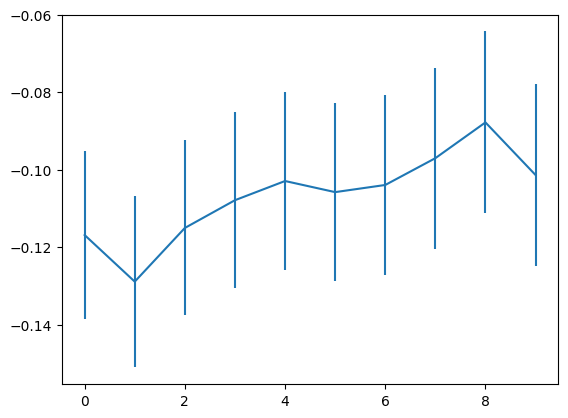

In [128]:
import matplotlib.pyplot as plt
plt.errorbar( [ k for k in range(10)] , df_comparison[['diff_0', 'diff_1', 'diff_2', 'diff_3', 'diff_4',
       'diff_5', 'diff_6', 'diff_7', 'diff_8', 'diff_9']].mean() , df_comparison[['diff_0', 'diff_1', 'diff_2', 'diff_3', 'diff_4',
       'diff_5', 'diff_6', 'diff_7', 'diff_8', 'diff_9']].sem()) 

In [28]:
pairs = ppps.merge(non_ppps, on = 'pair_id')
df_pairs = pd.DataFrame()
for k in range(10):
    df_pairs[k] = np.log(1+pairs['year_' + str(k) + '_x']) - np.log(1+pairs['year_' + str(k) + '_y'])

In [129]:
controls = pd.read_stata(main_path + 'PPPs_twins/anticommonsredux_emma.dta')


In [138]:
controls

,v1,paper_id,pair_id,score,ppp,paperpubyear,grant_year,app_year,app_pub_year,ppp_score,...,lpost_pub_pre_grant_self,lpre_grant_self,lpost_grant_self,apppublished,magid,lifesci,firstpage,lastpage,pagelength,numbackwardcites
0,174558,2.542010e+05,loose_twin_106981,NaN,1,2007,2013,2009,2010.0,3,...,0.0,0.0,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
1,185354,2.542010e+05,loose_twin_113721,NaN,1,2007,2014,2013,2013.0,3,...,0.0,0.0,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
2,118990,2.542010e+05,loose_twin_72395,NaN,1,2007,2006,2001,2003.0,1,...,0.0,0.0,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
3,138156,2.542010e+05,loose_twin_84134,NaN,1,2007,2009,2004,2006.0,3,...,0.0,0.0,0.000000,1,2.542010e+05,1,NaN,NaN,NaN,94
4,138249,2.678330e+05,loose_twin_84190,0.526003,0,2005,2009,2006,2007.0,4,...,0.0,0.0,0.693147,1,2.678330e+05,1,167.0,172.0,5.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245911,107445,4.213387e+09,loose_twin_65385,0.999963,0,2002,2004,1999,NaN,3,...,NaN,0.0,0.000000,0,4.213386e+09,0,NaN,NaN,NaN,0
245912,143963,4.213387e+09,loose_twin_87760,0.999963,0,2002,2010,2004,2005.0,3,...,0.0,0.0,0.000000,1,4.213386e+09,0,NaN,NaN,NaN,0
245913,21721,4.213419e+09,loose_twin_13662,0.535324,0,2022,2019,2017,2017.0,3,...,0.0,0.0,0.000000,1,4.213419e+09,0,NaN,NaN,NaN,0
245914,39198,4.213425e+09,loose_twin_24627,NaN,1,2016,2021,2017,2019.0,3,...,0.0,0.0,0.693147,1,4.213425e+09,0,NaN,NaN,NaN,0


In [181]:
matching = set([ "W" + str(int(elem)) for elem in controls[controls['ppp'] == 1]['paper_id']] ) & set(PPPs['paper_id'].tolist()) 